# Advanced RAG on HuggingFace documentation using langchain
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

In [66]:
# https://arc.net/l/quote/vntkseji
# https://huggingface.co/learn/cookbook/en/advanced_rag

# !pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl 

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # this will be helpful when visualizing retriever outputs

/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_50251/2935809469.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load your knowledge base

In [2]:
from langchain.docstore.document import Document as LangchainDocument
from langchain_community.document_loaders import DirectoryLoader

# RAW_KNOWLEDGE_BASE = [
#     LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
#     for doc in tqdm(ds)
# ]
webpages = 'data/webpages'
# https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory

loader = DirectoryLoader('data/webpages/', glob="**/*.txt")
docs = loader.load()
len(docs)

13

# 1. Retriever - embeddings 🗂️

### 1.1 Split the documents into chunks

In [35]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  
    chunk_overlap=100,  
    add_start_index=True,  
    strip_whitespace=True
    )

docs_processed = []
for doc in docs:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


  0%|          | 0/481 [00:00<?, ?it/s]

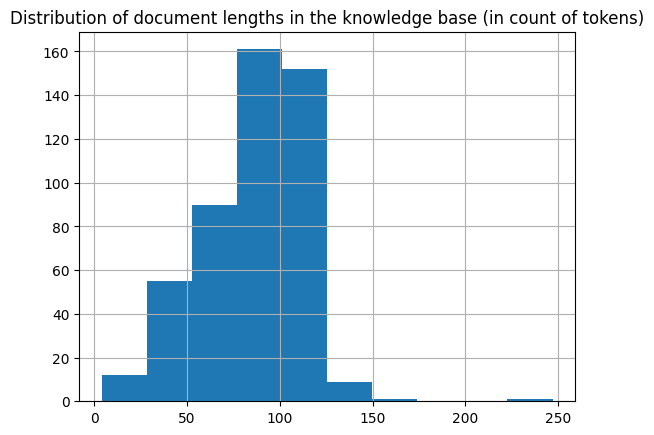

In [36]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

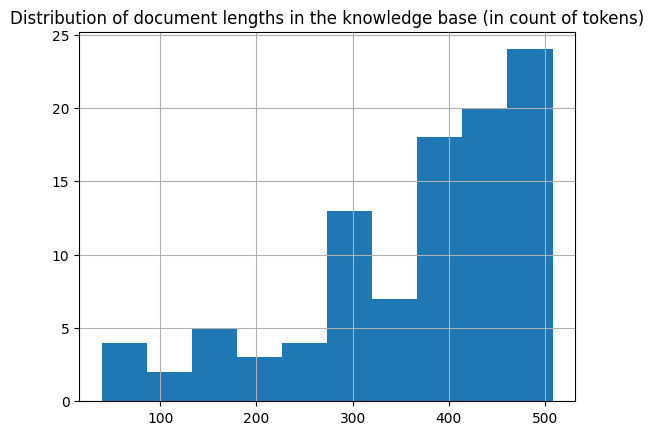

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    docs,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### 1.2 Building the vector database

##### Nearest Neighbor search algorithm

[FAISS](https://github.com/facebookresearch/faiss)

##### Distances
[here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings).
- **Cosine similarity** computes similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions are regardless of their magnitude. Using it requires to normalize all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

In [38]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    # model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [39]:
# embed a user query in the same space
user_query = 'What is the Buggy race schedule this year?'
query_vector = embedding_model.embed_query(user_query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [40]:
# import pacmap
# import numpy as np
# import plotly.express as px

# embedding_projector = pacmap.PaCMAP(
#     n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
# )

# embeddings_2d = [
#     list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
#     for idx in range(len(docs_processed))
# ] + [query_vector]

# # fit the data (The index of transformed data corresponds to the index of the original data)
# documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [41]:
# df = pd.DataFrame.from_dict(
#     [
#         {
#             "x": documents_projected[i, 0],
#             "y": documents_projected[i, 1],
#             "source": docs_processed[i].metadata["source"].split("/")[1],
#             "extract": docs_processed[i].page_content[:100] + "...",
#             "symbol": "circle",
#             "size_col": 4,
#         }
#         for i in range(len(docs_processed))
#     ]
#     + [
#         {
#             "x": documents_projected[-1, 0],
#             "y": documents_projected[-1, 1],
#             "source": "User query",
#             "extract": user_query,
#             "size_col": 100,
#             "symbol": "star",
#         }
#     ]
# )

# # visualize the embedding
# fig = px.scatter(
#     df,
#     x="x",
#     y="y",
#     color="source",
#     hover_data="extract",
#     size="size_col",
#     symbol="symbol",
#     color_discrete_map={"User query": "black"},
#     width=1000,
#     height=700,
# )
# fig.update_traces(
#     marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")), selector=dict(mode="markers")
# )
# fig.update_layout(
#     legend_title_text="<b>Chunk source</b>",
#     title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
# )
# fig.show()

In [45]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=1)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What is the Buggy race schedule this year?'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


==================================Top document==================================
Buggy Races Keep Rolling at Carnegie Mellon -

News - Carnegie Mellon University

Carnegie Mellon University

— — —

Buggy Races Keep Rolling at Carnegie Mellon

April 10, 2019

Buggy Races Keep Rolling at Carnegie Mellon

In its 99th year, the tradition is a Spring Carnival treat

By Heidi Opdyke

opdyke(through)andrew.cmu.edu

Media Inquiries

Julie Mattera

Marketing and Communications

jmattera(through)cmu.edu

412-268-2902

Sweepstakes, also known as the

Buggy Races , has come a long way at Carnegie Mellon University. The slick, torpedo-like vessels carrying drivers with nerves of steel are a far cry from the two-man teams that once changed places halfway through a race and rode in everything from rain barrels with bicycle wheels to three-wheeled ash cans 99 years ago.

Today, it takes six people to maneuver the .84 -mile course around Schenley Park's Flagstaff Hill.

But while five pushers and a dr

# 2. Reader - LLM 

### 2.1. Reader model


In [46]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import os 
# READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
# )
# model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
# tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

# READER_LLM = pipeline(
#     model=model,
#     tokenizer=tokenizer,
#     task="text-generation",
#     do_sample=True,
#     temperature=0.2,
#     repetition_penalty=1.1,
#     return_full_text=False,
#     max_new_tokens=500,
# )
# huggingfacehub_api_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
# # quantization_config = BitsAndBytesConfig(load_in_8bit=True)

# model = AutoModelForCausalLM.from_pretrained("google/gemma-2b",
#                                              # quantization_config=quantization_config,
#                                              token = huggingfacehub_api_token)
# tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b", token= huggingfacehub_api_token)



In [47]:
# smaller 
name = 'MBZUAI/LaMini-GPT-774M'
model = AutoModelForCausalLM.from_pretrained(name)
tokenizer = AutoTokenizer.from_pretrained(name)

In [48]:
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=20,
)

In [49]:
input = 'What is life?'
input_ids = tokenizer(input, return_tensors="pt")
outputs = model.generate(**input_ids)
print(tokenizer.decode(outputs[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is life?

The world's most interesting people usually have something to say about love, marriage, death, and the human condition.<|endoftext|>


In [30]:
READER_LLM('what do u think about the weather?')[0]['generated_text']

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"\n\nI'm sorry, I cannot provide an opinion as I am an artificial intelligence language model and"

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [50]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.<|endoftext|>Context:
{context}
---
Now here is the question you need to answer.

Question: {question}<|endoftext|>


Let's test our Reader on our previously retrieved documents!

In [51]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context
)

In [52]:
final_prompt

'Using the information contained in the context,\ngive a comprehensive answer to the question.\nRespond only to the question asked, response should be concise and relevant to the question.\nProvide the number of the source document when relevant.\nIf the answer cannot be deduced from the context, do not give an answer.<|endoftext|>Context:\n\nExtracted documents:\nDocument 0:::\nBuggy Races Keep Rolling at Carnegie Mellon -\n\nNews - Carnegie Mellon University\n\nCarnegie Mellon University\n\n— — —\n\nBuggy Races Keep Rolling at Carnegie Mellon\n\nApril 10, 2019\n\nBuggy Races Keep Rolling at Carnegie Mellon\n\nIn its 99th year, the tradition is a Spring Carnival treat\n\nBy Heidi Opdyke\n\nopdyke(through)andrew.cmu.edu\n\nMedia Inquiries\n\nJulie Mattera\n\nMarketing and Communications\n\njmattera(through)cmu.edu\n\n412-268-2902\n\nSweepstakes, also known as the\n\nBuggy Races , has come a long way at Carnegie Mellon University. The slick, torpedo-like vessels carrying drivers with ne

In [53]:
# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


The United States has been working to improve relations with Cuba since the end of the Cold War, but


### 2.3. Reranking

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to [the RAGatouille library](https://github.com/bclavie/RAGatouille).

In [56]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[Feb 23, 21:34:39] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/vashisth/anaconda3/envs/llama_hw/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


# 3. Assembling it all!

In [62]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 2,
    num_docs_final: int = 1,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

Let's see how our RAG pipeline answers a user query.

In [63]:
user_query

'What is the Buggy race schedule this year?'

In [64]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...
Your documents are roughly 264.0 tokens long at the 90th percentile! This is quite long and might slow down reranking!
 Provide fewer documents, build smaller chunks or run on GPU if it takes too long for your needs!


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


=> Generating answer...


In [65]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
The latest version of the popular game, Minecraft, has been released and it's now available for download
==================================Source docs==================================
Document 0------------------------------------------------------------
MIIS Capstone Project

Machine Translation

Spring 2:

Comp Semantics for NLP

Neural Networks for NLP

Elective

Example Course of Study #3 This example would satisfy course requirements for a student interested in deepening their expertise in Human Language area of concentration Fall 1: - Natural Language Processing - Algorithms for NLP - Intro to ML (MLD) - MIIS Directed Study

Spring 1:

Question Answering

Intro to Deep Learning

MIIS Capstone Planning Seminar

MIIS Directed Study

Summer:

Internship

Fall 2:

MIIS Capstone Project

Language and Statistics

Spring 2:

Comp Semantics for NLP

ML for Signal Processing

Elective

Admission Carnegie Mellon's 